
# Ejemplo 5.1: Convección-Difusión 1D con Diferencias Centradas (CDS)
 
Este notebook analiza un problema de **convección-difusión 1D** y demuestra una de las limitaciones más importantes del esquema de **Diferencias Centradas (CDS)**.

### Planteamiento del Problema

Una propiedad $\phi$ es transportada a través de un dominio 1D por convección (flujo) y difusión.

**Ecuación Gobernante:**
$$ \frac{d}{dx}(\rho u \phi) = \frac{d}{dx}\left(\Gamma\frac{d\phi}{dx}\right) $$

**Datos:**
- Longitud, $L = 1.0 \, m$
- Densidad, $\rho = 1.0 \, kg/m^3$
- Coeficiente de difusión, $\Gamma = 0.1 \, kg/(m \cdot s)$
- Condiciones de frontera: $\phi(0) = 1$ y $\phi(L) = 0$.

### El Número de Péclet

La física de este problema está gobernada por la relación entre la fuerza de la convección y la de la difusión. Esta relación se mide con el **Número de Péclet de celda (Pe)**:
$$ Pe = \frac{F}{D} = \frac{\rho u}{\Gamma / \delta x} = \frac{\rho u \delta x}{\Gamma} $$

- Si **Pe < 2**, la difusión es dominante o significativa. El esquema CDS es estable y preciso.
- Si **Pe > 2**, la convección domina. El esquema CDS se vuelve inestable y puede producir **oscilaciones no físicas** en la solución.

### Solución Analítica
$$ \frac{\phi - \phi_0}{\phi_L - \phi_0} = \frac{e^{(\rho u x / \Gamma)} - 1}{e^{(\rho u L / \Gamma)} - 1} $$

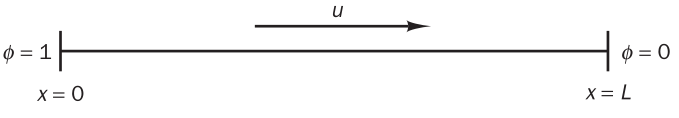

In [47]:
from mnspy import Vertice, Celda, Superficie, VolumenFinito, SuperficieDirichlet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Caso 1: Flujo de baja velocidad (Dominado por Difusión)

Se analiza el caso con una velocidad baja, $u = 0.1 \, m/s$.

**Cálculo del Número de Péclet:**
- $u = 0.1 \, m/s$
- $\delta x = 0.2 \, m$ (para 5 celdas)
- $Pe = \frac{1.0 \times 0.1 \times 0.2}{0.1} = 0.2$

Como **Pe < 2**, se espera que el esquema CDS produzca una solución precisa.

### --- Configuración del Problema ---

In [48]:
L = 1.0
n_celdas = 5
phi_0 = 1
phi_L = 0
delta_x = L / n_celdas
Gamma = 0.1
A = 1
dens = 1.0
u = [0.1, 0.0, 0.0]

#### --- Discretización ---

In [49]:
v = [Vertice(str(i), i*delta_x) for i in range(n_celdas + 1)]
s = [SuperficieDirichlet('0',[0], {'T': phi_0}, A,u=u)]
for i in range(1, n_celdas):
    s.append(Superficie(str(i),[i], A,u=u))
s.append(SuperficieDirichlet(str(n_celdas),[n_celdas], {'T': phi_L}, A,u=u))
c = [Celda(str(i+1),[i,i+1], gamma=Gamma,densidad=dens) for i in range(n_celdas)]

#### --- Solución ---

In [50]:
vol = VolumenFinito(v,s,c)

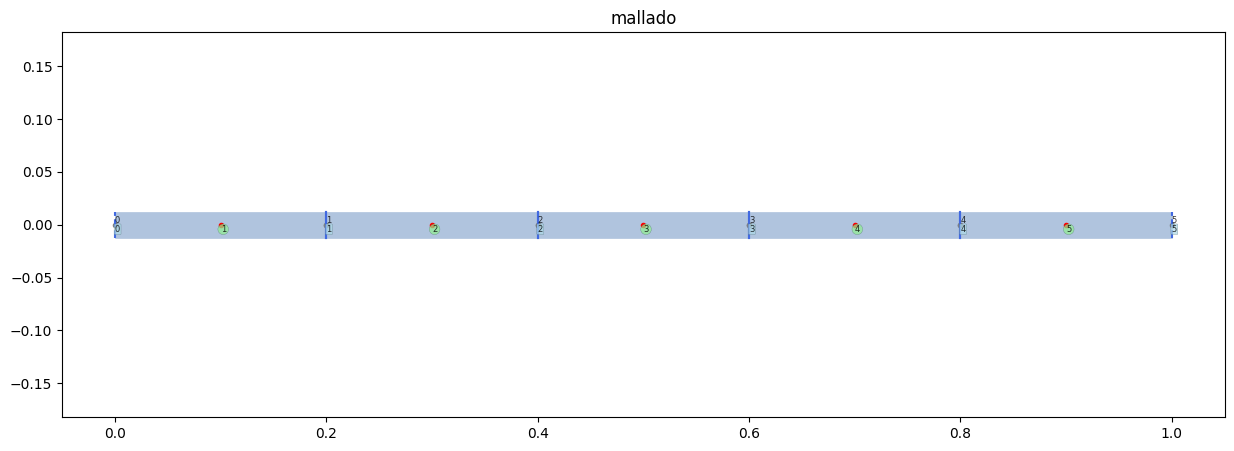

In [51]:
vol.mallado()

In [52]:
vol.mostrar_ecuaciones()

<IPython.core.display.Math object>

In [53]:
vol.solucionar_por_Gauss()
vol.mostrar_sistema_lineal_ecuaciones()

<IPython.core.display.Math object>

In [54]:
vol._sol.solucion()

,Solución
$T_{1}$,0.94211
$T_{2}$,0.800601
$T_{3}$,0.627646
$T_{4}$,0.416256
$T_{5}$,0.15789


## Análisis de Resultados (Caso 1)
### --- Post-procesamiento y Comparación ---


In [55]:
# Función para la solución analítica
def phi_analitica(x, rho, u, Gamma, L, phi_0, phi_L):
    numer = np.exp(rho * u * x / Gamma) - 1
    denom = np.exp(rho * u * L / Gamma) - 1
    if np.isclose(denom, 0): return phi_0 + (phi_L - phi_0) * x / L
    return phi_0 + (phi_L - phi_0) * numer / denom

In [56]:
# Tabla comparativa
x_numeric = np.array([celda.centroide.x for celda in vol.celdas])
phi_numeric = vol.get_solucion().flatten()

datos = {'Distancia': x_numeric, 'Solución FVM': phi_numeric}
tabla = pd.DataFrame(datos, index = [c.nombre for c in vol.celdas])
tabla.index.name='Celda'
tabla['Solución Analítica'] = phi_analitica(x_numeric, dens, u[0], Gamma, L, phi_0, phi_L)
tabla['Error Absoluto'] = tabla['Solución Analítica'] - tabla['Solución FVM']
tabla['% Error Relativo'] = (100 * np.abs(tabla['Error Absoluto'] / tabla['Solución Analítica'])).map('{:.2f}%'.format)
tabla

,Distancia,Solución FVM,Solución Analítica,Error Absoluto,% Error Relativo
Celda,,,,,
1,0.1,0.942110,0.938793,-0.003317,0.35%
2,0.3,0.800601,0.796390,-0.004211,0.53%
3,0.5,0.627646,0.622459,-0.005186,0.83%
4,0.7,0.416256,0.410020,-0.006236,1.52%
5,0.9,0.157890,0.150545,-0.007345,4.88%


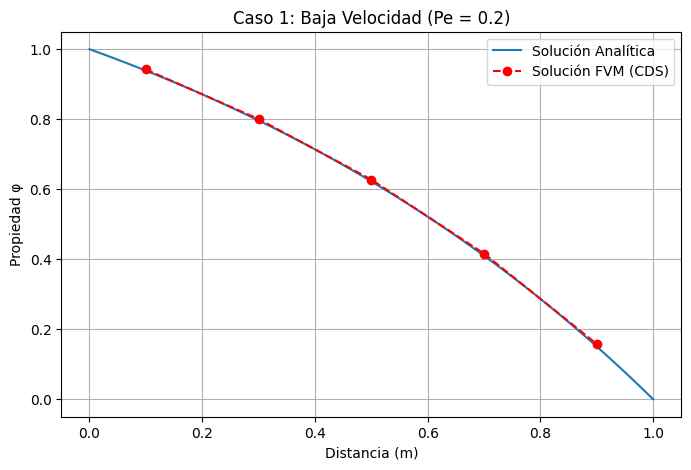

In [57]:
# Gráfica comparativa
x_analytic = np.linspace(0, L, 100)
y_analytic = phi_analitica(x_analytic, dens, u[0], Gamma, L, phi_0, phi_L)

plt.figure(figsize=(8,5))
plt.plot(x_analytic, y_analytic, label='Solución Analítica')
plt.plot(x_numeric, phi_numeric, 'o--', c='r', label='Solución FVM (CDS)')
plt.legend()
plt.grid()
plt.title('Caso 1: Baja Velocidad (Pe = 0.2)')
plt.xlabel('Distancia (m)')
plt.ylabel('Propiedad φ')
plt.show()

**Conclusión (Caso 1):** Como se esperaba, con un Péclet bajo, la solución numérica es muy precisa y no presenta oscilaciones.

## Caso 2: Flujo de alta velocidad (Dominado por Convección)

Ahora se aumenta la velocidad a $u = 2.5 \, m/s$.

**Cálculo del Número de Péclet:**
- $u = 2.5 \, m/s$
- $\delta x = 0.2 \, m$ (5 celdas)
- $Pe = \frac{1.0 \times 2.5 \times 0.2}{0.1} = 5.0$

Como **Pe > 2**, se espera que el esquema CDS falle y produzca una solución con oscilaciones no físicas.

### --- Configuración y Solución ---

In [58]:
u = [2.5, 0.0, 0.0]
v = [Vertice(str(i), i*delta_x) for i in range(n_celdas + 1)]
s = [SuperficieDirichlet('0',[0], {'T': phi_0}, A,u=u)]
for i in range(1, n_celdas):
    s.append(Superficie(str(i),[i], A,u=u))
s.append(SuperficieDirichlet(str(n_celdas),[n_celdas], {'T': phi_L}, A,u=u))
c = [Celda(str(i+1),[i,i+1], gamma=Gamma,densidad=dens) for i in range(n_celdas)]

In [59]:
vol = VolumenFinito(v,s,c)

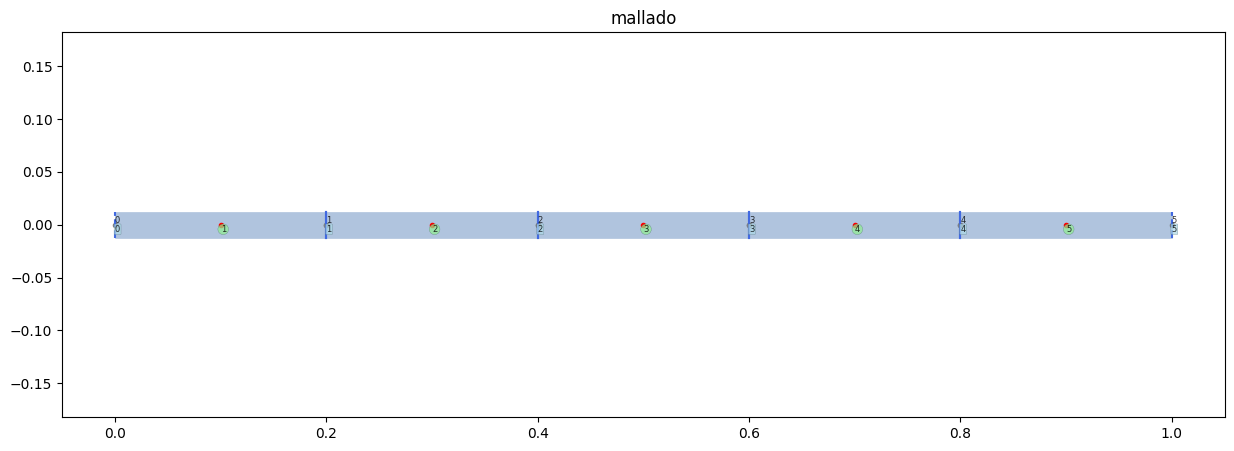

In [60]:
vol.mallado()

In [61]:
vol.mostrar_ecuaciones()

<IPython.core.display.Math object>

In [62]:
vol.solucionar_por_Gauss()
vol.mostrar_sistema_lineal_ecuaciones()

<IPython.core.display.Math object>

In [63]:
vol._sol.solucion()

,Solución
$T_{1}$,1.03563
$T_{2}$,0.869355
$T_{3}$,1.25733
$T_{4}$,0.352053
$T_{5}$,2.46437


## Análisis de Resultados (Caso 2)
### --- Post-procesamiento y Comparación ---

In [64]:
x_numeric = np.array([celda.centroide.x for celda in vol.celdas])
phi_numeric = vol.get_solucion().flatten()

datos = {'Distancia': x_numeric, 'Solución FVM': phi_numeric}
tabla = pd.DataFrame(datos, index = [c.nombre for c in vol.celdas])
tabla.index.name='Celda'
tabla['Solución Analítica'] = phi_analitica(x_numeric, dens, u[0], Gamma, L, phi_0, phi_L)
tabla['Error Absoluto'] = tabla['Solución Analítica'] - tabla['Solución FVM']
tabla['% Error Relativo'] = (100 * np.abs(tabla['Error Absoluto'] / tabla['Solución Analítica'])).map('{:.2f}%'.format)
tabla

,Distancia,Solución FVM,Solución Analítica,Error Absoluto,% Error Relativo
Celda,,,,,
1,0.1,1.035630,1.000000,-0.035630,3.56%
2,0.3,0.869355,1.000000,0.130645,13.06%
3,0.5,1.257331,0.999996,-0.257335,25.73%
4,0.7,0.352053,0.999447,0.647394,64.78%
5,0.9,2.464370,0.917915,-1.546455,168.47%


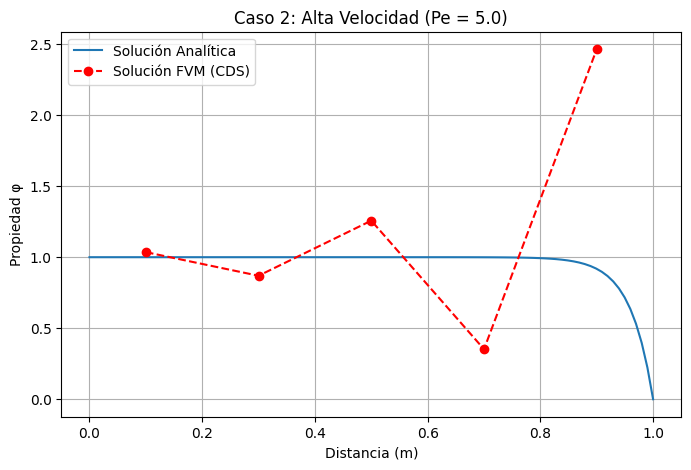

In [65]:
x_analytic = np.linspace(0, L, 100)
y_analytic = phi_analitica(x_analytic, dens, u[0], Gamma, L, phi_0, phi_L)

plt.figure(figsize=(8,5))
plt.plot(x_analytic, y_analytic, label='Solución Analítica')
plt.plot(x_numeric, phi_numeric, 'o--', c='r', label='Solución FVM (CDS)')
plt.legend()
plt.grid()
plt.title('Caso 2: Alta Velocidad (Pe = 5.0)')
plt.xlabel('Distancia (m)')
plt.ylabel('Propiedad φ')
plt.show()

**Conclusión (Caso 2):** La solución numérica es completamente errónea. Presenta oscilaciones severas y valores fuera del rango físico [0, 1]. Esto se debe a que el Número de Péclet es mayor que 2, lo que viola la condición de estabilidad del esquema CDS.

## Caso 3: Flujo de alta velocidad con Malla Fina

Se repite el caso de alta velocidad ($u = 2.5 \, m/s$), pero ahora se refina la malla, usando 20
celdas en lugar de 5.

**Cálculo del Número de Péclet:**
- $u = 2.5 \, m/s$
- $\delta x = 1.0 / 20 = 0.05 \, m$
- $
Pe = \frac{1.0 \times 2.5 \times 0.05}{0.1} = 1.25$

Al refinar la malla, el Péclet de celda ahora es **Pe < 2**. Esto satisface la condición de estabilidad del esquema CDS, por lo que se espera que la solución sea precisa y libre de oscilaciones.

### --- Configuración y Solución ---

In [66]:
n_celdas = 20
delta_x = L / n_celdas
u = [2.5, 0.0, 0.0]

v = [Vertice(str(i), i*delta_x) for i in range(n_celdas + 1)]
s = [SuperficieDirichlet('0',[0], {'T': phi_0}, A,u=u)]
for i in range(1, n_celdas):
    s.append(Superficie(str(i),[i], A,u=u))
s.append(SuperficieDirichlet(str(n_celdas),[n_celdas], {'T': phi_L}, A,u=u))
c = [Celda(str(i+1),[i,i+1], gamma=Gamma,densidad=dens) for i in range(n_celdas)]

In [67]:
vol = VolumenFinito(v,s,c)

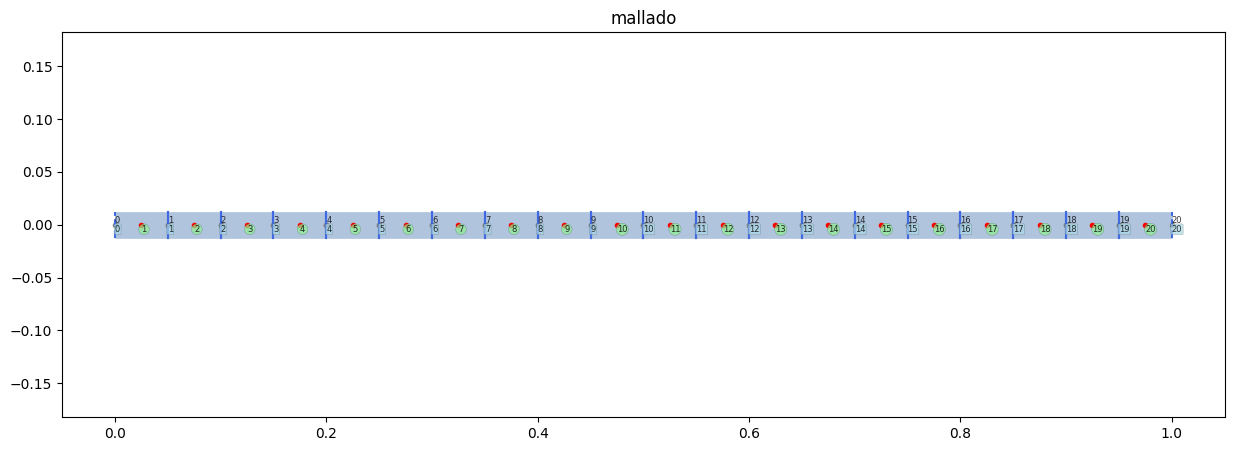

In [68]:
vol.mallado()

In [69]:
vol.mostrar_ecuaciones()

<IPython.core.display.Math object>

In [70]:
vol.solucionar_por_Gauss()
vol.mostrar_sistema_lineal_ecuaciones()

<IPython.core.display.Math object>

In [71]:
vol._sol.solucion()

,Solución
$T_{1}$,1
$T_{2}$,1
$T_{3}$,1
$T_{4}$,1
$T_{5}$,1
$T_{6}$,1
$T_{7}$,1
$T_{8}$,1
$T_{9}$,1
$T_{10}$,1


#### Análisis de Resultados (Caso 3)
# --- Post-procesamiento y Comparación ---

In [74]:
x_numeric = np.array([celda.centroide.x for celda in vol.celdas])
phi_numeric = vol.get_solucion().flatten()

datos = {'Distancia': x_numeric, 'Solución FVM': phi_numeric}
tabla = pd.DataFrame(datos, index = [c.nombre for c in vol.celdas])
tabla.index.name='Celda'
tabla['Solución Analítica'] = phi_analitica(x_numeric, dens, u[0], Gamma, L, phi_0, phi_L)
tabla['Error Absoluto'] = tabla['Solución Analítica'] - tabla['Solución FVM']
tabla['% Error Relativo'] = (100 * np.abs(tabla['Error Absoluto'] / tabla['Solución Analítica'])).map('{:.2f}%'.format)
tabla

,Distancia,Solución FVM,Solución Analítica,Error Absoluto,% Error Relativo
Celda,,,,,
1,0.025,1.000000,1.000000,-1.194345e-11,0.00%
2,0.075,1.000000,1.000000,-7.556444e-11,0.00%
3,0.125,1.000000,1.000000,-2.967855e-10,0.00%
4,0.175,1.000000,1.000000,-1.065292e-09,0.00%
5,0.225,1.000000,1.000000,-3.731914e-09,0.00%
6,0.275,1.000000,1.000000,-1.297117e-08,0.00%
7,0.325,1.000000,1.000000,-4.492395e-08,0.00%
8,0.375,1.000000,1.000000,-1.551701e-07,0.00%
9,0.425,1.000000,0.999999,-5.344200e-07,0.00%


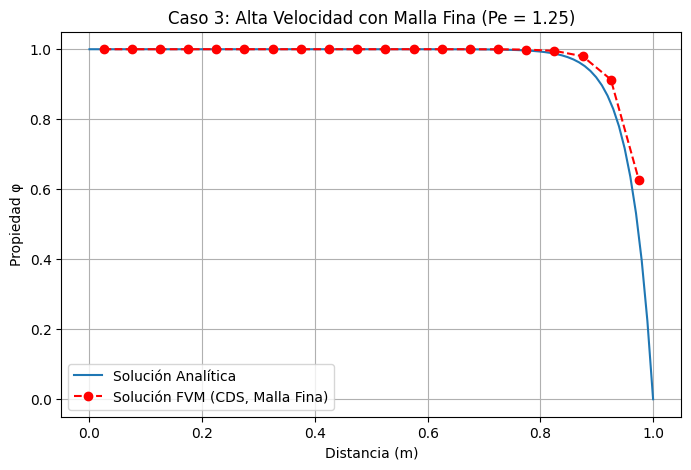

In [75]:
# Gráfica comparativa
x_analytic = np.linspace(0, L, 100)
y_analytic = phi_analitica(x_analytic, dens, u[0], Gamma, L, phi_0, phi_L)

plt.figure(figsize=(8,5))
plt.plot(x_analytic, y_analytic, label='Solución Analítica')
plt.plot(x_numeric, phi_numeric, 'o--', c='r', label='Solución FVM (CDS, Malla Fina)')
plt.legend()
plt.grid()
plt.title('Caso 3: Alta Velocidad con Malla Fina (Pe = 1.25)')
plt.xlabel('Distancia (m)')
plt.ylabel('Propiedad φ')
plt.show()

**Conclusión (Caso 3):** Al refinar la malla, la solución numérica ahora coincide muy bien con la solución analítica. Las oscilaciones han desaparecido y el resultado es físicamente correcto.

### Conclusiones Generales del Ejemplo 5.1

1.  **La Importancia del Número de Péclet**: El Péclet de celda ($Pe$) es el indicador clave para la estabilidad del esquema de Diferencias Centradas. Si $Pe > 2$, el método es propenso a generar resultados no físicos.
2.  **Limitación del Esquema CDS**: Aunque el CDS es formalmente de segundo orden (más preciso que otros esquemas en teoría), su requisito de estabilidad lo hace poco práctico para problemas dominados por convección, a menos que se utilicen mallas extremadamente finas.
3.  **El Costo del Refinamiento**: Refinar la malla para satisfacer la condición $Pe < The code change produced by Gemini could not be fully parsed. Can't automatically accept changes.